In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import spacy
import nltk
from spacy.lang.en import stop_words

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.ensemble import VotingClassifier

import re

In [5]:
df = pd.read_csv("../data/data_email.csv")
df.head()

,email,label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,spam
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam
3,##############################################...,spam
4,I thought you might like these:\n1) Slim Down ...,spam


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11797 entries, 0 to 11796
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   11796 non-null  object
 1   label   11797 non-null  object
dtypes: object(2)
memory usage: 184.5+ KB


In [6]:
df["email"] = df["email"].astype(str)
df["label"] = df["label"].astype(str)

## Data Visualization

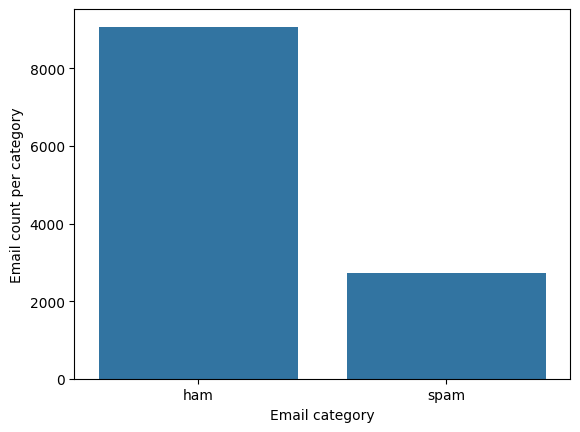

In [41]:
sns.barplot(df["label"].value_counts())
plt.ylabel("Email count per category")
plt.xlabel("Email category")
plt.show()

## Data cleaning and preprocessing

In [7]:
def clean_text_with_regex(text):
    regex = r'[^A-Za-z\s]'
    return " ".join(re.sub(regex, '', text).replace("\n", "").rsplit()).lower()

In [8]:
df["email"] = df["email"].apply(clean_text_with_regex)

In [9]:
nlp = spacy.load("en_core_web_sm")
stop_words = stop_words.STOP_WORDS

def preprocess_text(text):
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc if token.lemma_ not in stop_words and len(token.lemma_) > 1]
    processed_text = ' '.join(lemmatized_words)
    return processed_text

In [10]:
df["email"] = df["email"].apply(preprocess_text)

In [46]:
df["email"]

0        save life insurancewhy spend tolife quote savi...
1        fight risk cancerhttpwwwadclickwspcfmospk slim...
2        fight risk cancerhttpwwwadclickwspcfmospk slim...
3        adult club offer free membership instant acces...
4        think like slim guarantee lose lbs dayshttpwww...
                               ...                        
11792           pleased inform refund process successfully
11793    rich quick invest revolutionary new scheme ret...
11794    free trial period end soon upgrade continue en...
11795             order way track shipment realtime update
11796                limitedtime offer purchase today miss
Name: email, Length: 11797, dtype: object

## Spliting Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df["email"], df["label"], test_size=0.2, random_state=42)

## Testing unitary models

In [49]:
svc_classifier = SVC(probability=True, random_state=42, kernel='sigmoid', gamma="auto")

pipe_svc = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model', svc_classifier)
])

pipe_svc.fit(X_train, y_train)
pipe_svc.score(X_test, y_test)

0.7593220338983051

In [50]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(2000, 1000, 300, 100, 10), max_iter=5000, solver='adam', activation='relu', random_state=42)

pipe_mlp = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model', mlp_classifier)
])

pipe_mlp.fit(X_train, y_train)
pipe_mlp.score(X_test, y_test)

0.9525423728813559

In [51]:
decision_tree_classifier = DecisionTreeClassifier(random_state=42)

pipe_dtc = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model', decision_tree_classifier)
])

pipe_dtc.fit(X_train, y_train)
pipe_dtc.score(X_test, y_test)

0.8872881355932203

In [52]:
random_forest_classifier = RandomForestClassifier(random_state=42)

pipe_rfc = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model', random_forest_classifier)
])

pipe_rfc.fit(X_train, y_train)
pipe_rfc.score(X_test, y_test)

0.9394067796610169

In [53]:
naive_bayes_classifier = MultinomialNB()

pipe_nbc = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model', naive_bayes_classifier)
])

pipe_nbc.fit(X_train, y_train)
pipe_nbc.score(X_test, y_test)

0.877542372881356

In [58]:
for i in range(3, 10, 2):
    knn_classifier = KNeighborsClassifier(n_neighbors=i, weights="distance", n_jobs=3)

    pipe_knn = Pipeline([
        ('vect', TfidfVectorizer()),
        ('model', knn_classifier)
    ])

    pipe_knn.fit(X_train, y_train)
    
    print(f"{i} neighbors: {pipe_knn.score(X_test, y_test)}")

3 neighbors: 0.4966101694915254
5 neighbors: 0.5080508474576271
7 neighbors: 0.41567796610169494
9 neighbors: 0.3644067796610169


## Building the model

I chose just the models that got an score higher than 80%

In [61]:
ensemble_classifier = VotingClassifier(estimators=[
    ('mlp', mlp_classifier),
    ('decision_tree', decision_tree_classifier),
    ('random_forest', random_forest_classifier),
    ('naive_bayes', naive_bayes_classifier),
], voting='soft', n_jobs=3, weights=[0.8, 0.6, 0.7, 0.5], verbose=True) 

In [62]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', ensemble_classifier)
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 VotingClassifier(estimators=[('mlp',
                                               MLPClassifier(hidden_layer_sizes=(2000,
                                                                                 1000,
                                                                                 300,
                                                                                 100,
                                                                                 10),
                                                             max_iter=5000,
                                                             random_state=42)),
                                              ('decision_tree',
                                               DecisionTreeClassifier(random_state=42)),
                                              ('random_forest',
                                               RandomForestClassifier(random_state=42)),
                                              ('naive_bayes', MultinomialNB())],
                                  n_jobs=3, verbose=True, voting='soft',
                                  weights=[0.8, 0.6, 0.7, 0.5]))])

## Saving the model

In [2]:
import pickle

In [64]:
pickle.dump(pipeline, open("email-classifier.pkl", 'wb'))

## Results

In [3]:
pipeline = pickle.load(open('./email-classifier.pkl', 'rb'))

## Results

In [67]:
pipeline.score(X_test, y_test)

0.9529661016949152

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [13]:
y_pred = pipeline.predict(X_test)

In [14]:
accuracy_score(y_test, y_pred)

0.9529661016949152

In [25]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         ham       0.97      0.96      0.97      1792
        spam       0.89      0.92      0.90       568

    accuracy                           0.95      2360
   macro avg       0.93      0.94      0.94      2360
weighted avg       0.95      0.95      0.95      2360



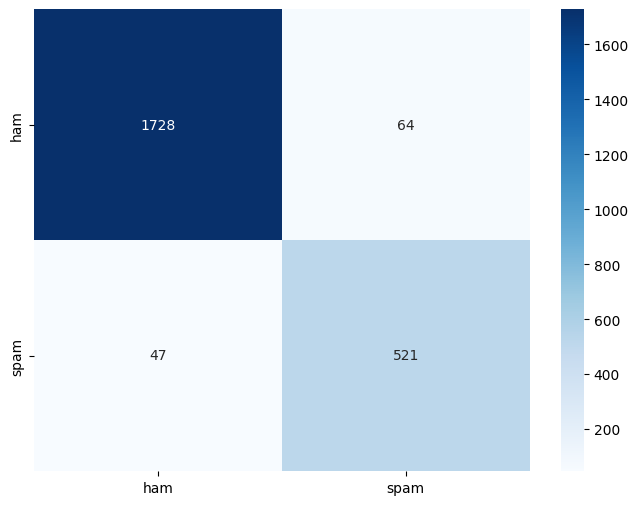

In [23]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.show()